In [60]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from scipy import special
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import h5py
from matplotlib.ticker import MaxNLocator



#Displacement in z due to a mctigue source

def mctigue(r):
    d = 20e3 #depth
    mu = 40e9 #shear modulus
    p = 5e6 #magma body pressure
    a = 5e3 #radius of body
    
    return (3*p*a**3)/(4*mu)*d/(r**2 + d**2)**1.5

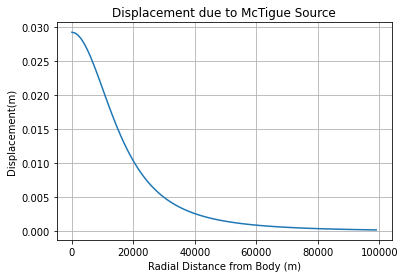

In [61]:
r = np.arange(0.0, 100000, 1000)

fig, ax = plt.subplots()
ax.plot(r, mctigue(r))

ax.set(xlabel='Radial Distance from Body (m)', ylabel='Displacement(m)',
       title='Displacement due to McTigue Source')
ax.grid()

plt.show()

In [13]:
#Fialko Solution to pressurized crack

R = 25e3 #Radius of crack (m)
H = 20e3 #Depth of crack (m)
h = H/R #normalized height
nu = 0.25 #poisson's ration
mu = 40e9 #shear modulus (Pa)
p = 5e6 #magma body pressure (Pa)
#---------------------------------------------#
# Kernal functions must be defined first
#---------------------------------------------#

def P1(x):
    return (12*h**2 - x**2)/(4*h**2 + x**2)**3

def P2(x):
    return np.log(4*h**2 + x**2) + (8*h**4 + 2*x**2*h**2 - x**4)/(4*h**2 + x**2)**2

def P3(x):
    return 2*(8*h**4 - 2*x**2*h**2 + x**4)/(4*h**2 + x**2)**3

def P4(x):
    return (4*h**2-x**2)/(4*h**2+x**2)**2 

def T1(t, r):
    return 4*h**3*(P1(t-r)-P1(t+r))

def T2(t, r):
    return (h/(t*r))*(P2(t-r) - P2(t+r)) + h*(P3(t-r) + P3(t+r))

def T3(t, r):
    return (h**2/r)*(P4(t-r)-P4(t+r) - 2*r*((t-r)*P1(t-r) + (t+r)*P1(t+r)))

def T4(t, r):
    return T3(t, r)

In [14]:
#---------------------------------------#
# Solve phi bar and psi bar 
# with successive approximations
#---------------------------------------#
max_itr = 100
max_tol = 0.0001
arr_size = 20
converged = True

phi_bar = np.empty([arr_size,])
psi_bar = np.empty([arr_size,]) 
prev_phi_bar = np.empty([arr_size,])
prev_psi_bar = np.empty([arr_size,])

for n in range(0, max_itr):
    print(n)
    if n == 0:
        for t in np.linspace(0, 1, num=arr_size, endpoint=False):
            prev_phi_bar[math.floor(t*arr_size)] = (-2*t/np.pi)#base case from Fialko paper
            prev_psi_bar[math.floor(t*arr_size)] = 0.0 #base case from Fialko paper
    func_prev_phi_bar = interpolate.interp1d(np.linspace(0, 1, num=arr_size), prev_phi_bar)
    func_prev_psi_bar = interpolate.interp1d(np.linspace(0, 1, num=arr_size), prev_psi_bar)
    
    for t in np.linspace(0, 1, num=arr_size, endpoint=False):
        if t == 0:
            phi_bar[math.floor(t*arr_size)] = 0.0
            psi_bar[math.floor(t*arr_size)] = 0.0
        else:
            #phi_bar array
            r = np.linspace(0, 1, num=arr_size, endpoint=False)
            r[0] += 0.00001
            integrand = lambda r: T1(t, r)*func_prev_phi_bar(r) + T3(t, r)*func_prev_psi_bar(r)
            phi_bar[math.floor(t*arr_size)] = -(2*t/(np.pi)) + (2/np.pi)*integrate.quad(integrand, 0.001, 1)[0]
            
             #psi_bar array
            integrand = lambda r: T2(t, r)*func_prev_psi_bar(r) + T4(t, r)*func_prev_phi_bar(r)
            psi_bar[math.floor(t*arr_size)] = (2/np.pi)*integrate.quad(integrand, 0.001, 1)[0]
            
        
        phi_bar_tol = abs(phi_bar[math.floor(t*arr_size)] - prev_phi_bar[math.floor(t*arr_size)]) 
        psi_bar_tol = abs(psi_bar[math.floor(t*arr_size)] - prev_psi_bar[math.floor(t*arr_size)])
    
        #print(phi_bar_tol, psi_bar_tol)
        if phi_bar_tol > max_tol or psi_bar_tol > max_tol:
            converged = False
    #print(phi_bar[0], psi_bar[0])
    if converged:
        break
    
    prev_phi_bar = np.copy(phi_bar)
    prev_psi_bar = np.copy(psi_bar)
    converged = True
        
    



0
1


/tmp/ipykernel_2915/3211150437.py:33: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  phi_bar[math.floor(t*arr_size)] = -(2*t/(np.pi)) + (2/np.pi)*integrate.quad(integrand, 0.001, 1)[0]
/tmp/ipykernel_2915/3211150437.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  psi_bar[math.floor(t*arr_size)] = (2/np.pi)*integrate.quad(integrand, 0.001, 1)[0]


2
3
4
5
6
7


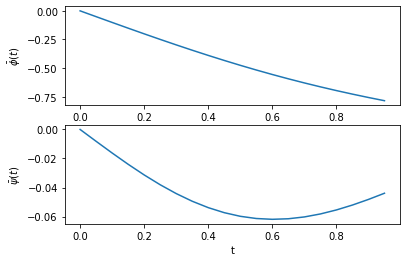

In [15]:
#Interpolate functions
func_phi_bar = interpolate.interp1d(np.linspace(0, 1, num=arr_size), phi_bar)
func_psi_bar = interpolate.interp1d(np.linspace(0, 1, num=arr_size), psi_bar)


#Check phi bar and psi bar by plotting them
t = np.linspace(0, 1, num=arr_size, endpoint=False)

fig, ax = plt.subplots(2)
ax[0].set(xlabel='t', ylabel=r'$\bar{\phi}(t)$')
ax[0].plot(t, func_phi_bar(t))

ax[1].set(xlabel='t', ylabel=r'$\bar{\psi}(t)$')
ax[1].plot(t, func_psi_bar(t))

#ax.grid()

plt.show()

In [16]:
#---------------------------------------------#
# Functions for final integration
# Convention for indicies: $S_0^1$ --> S01
#                          $S_1^{-1} -> S1neg1
#---------------------------------------------#

def X1(t, r):
    return h**2 + r**2 - t**2

def X2(t, r):
    return np.sqrt(X1(t, r)**2 + 4*h**2*t**2)

def S00(t, r):
    return (np.sqrt(2)*h*t)/(X2(t, r)*np.sqrt(X2(t, r)+X1(t, r)))

def S01(t, r):
    num =  (h*np.sqrt(X2(t, r)-X1(t, r))*(2*X1(t, r)+X2(t, r)) - t*np.sqrt(X2(t, r) + X1(t, r))*(2*X1(t, r)-X2(t, r)))
    denom = np.sqrt(2)*X2(t, r)**3
    return num/denom

def C01(t, r):
    num =  (h*np.sqrt(X2(t, r)+X1(t, r))*(2*X1(t, r)-X2(t, r)) + t*np.sqrt(X2(t, r) - X1(t, r))*(2*X1(t, r)+X2(t, r)))
    denom = np.sqrt(2)*X2(t, r)**3
    return num/denom

def S1neg1(t, r):
    return (t/r) - np.sqrt(X2(t, r)-X1(t, r))/(np.sqrt(2)*r)

def S10(t, r):
    num = t*np.sqrt(X2(t, r) + X1(t, r)) - h*np.sqrt(X2(t, r)-X1(t, r))
    denom = np.sqrt(2)*r*X2(t, r)
    return num/denom

def C10(t, r):
    num = h*np.sqrt(X2(t, r)+X1(t, r)) + t*np.sqrt(X2(t, r)-X1(t, r))
    denom = np.sqrt(2)*r*X2(t, r)
    return (1/r) - (num/denom)

def C11(t, r):
    return (r*np.sqrt(X2(t, r)+X1(t, r))*(2*X1(t, r)-X2(t, r)))/(np.sqrt(2)*X2(t, r)**3)

def S11(t, r):
    return (r*np.sqrt(X2(t, r)-X1(t, r))*(2*X1(t, r) + X2(t, r)))/(np.sqrt(2)*X2(t, r)**3)

#print(S00(0, 0), S01(0, 0), C01(0, 0))
#--------------------------------#
# Big Phi and Theta
#--------------------------------#
def Phi(xi):
    integrand = lambda t: np.sin(xi*t)*func_phi_bar(t)
    return integrate.quad(integrand, 0, 1, limit=1000)[0]


def Psi(xi):
    integrand = lambda t: ((np.sin(xi*t))/(xi*t) - np.cos(xi*t))*func_psi_bar(t)
    return integrate.quad(integrand, 0, 1, limit=1000)[0]


In [17]:
#--------------------------------------#
# Semi-analytical surface displacements
#--------------------------------------#

def Uz(r):
    print(r)
    integrand = lambda xi:((1 + xi*h)*Phi(xi) + xi*h*Psi(xi))*np.exp(-xi*h)*special.jv(0, xi*r)
    return integrate.quad(integrand, 0, np.inf, limit=1000)[0]

def Ur(r):
    print(r)
    integrand = lambda xi: ((1-xi*h)*Psi(xi)-xi*h*Phi(xi))*np.exp(-xi*h)*special.jv(1, xi*r)
    return integrate.quad(integrand, 0, np.inf, limit=1000)[0]

# def Uz(r):
#     integrand1 = lambda t: (S00(t, r) + h*S01(t, r))*func_phi_bar(t)
#     integrand2 = lambda t: ((np.sqrt(2)*h)/(X2(t, r)*np.sqrt(X2(t, r) + X1(t, r))) - C01(t, r))*func_psi_bar(t)
    
#     #print(integrand1(0.1), integrand2(0.1))
        
#     result = integrate.quad(integrand1, 0, 1, limit=100)[0] + integrate.quad(integrand2, 0, 1, limit=100)[0]
#     return result

# def Ur(r):
#     integrand1 = lambda t: ((S1neg1(t, r)-h*S10(t, r))/t - C10(t, r) + h*C11(t, r))*func+phi_bar(t)
#     integrand2 = lambda t: S11(t, r)*func_phi_bar(t)
    
#     result = integrate.quad(integrand1, 0, 1, limit=100) - h*integrate.quad(integrand2, 0, 1, limit=100)
#     return result



#print(Uz(0.0), Ur(0.0))
r = np.linspace(0, 5, num=arr_size)
uz_vec = np.vectorize(Uz)
ur_vec = np.vectorize(Ur)
uz_plot = uz_vec(r)
ur_plot = ur_vec(r)

0.0


/tmp/ipykernel_2915/3482025475.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(integrand, 0, 1, limit=1000)[0]


0.0
0.2631578947368421
0.5263157894736842
0.7894736842105263
1.0526315789473684
1.3157894736842104


/tmp/ipykernel_2915/3482025475.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(integrand, 0, 1, limit=1000)[0]


1.5789473684210527
1.8421052631578947
2.1052631578947367
2.3684210526315788
2.631578947368421
2.894736842105263
3.1578947368421053
3.4210526315789473
3.6842105263157894
3.9473684210526314
4.2105263157894735
4.473684210526316
4.7368421052631575
5.0
0.0
0.0
0.2631578947368421
0.5263157894736842
0.7894736842105263
1.0526315789473684
1.3157894736842104
1.5789473684210527
1.8421052631578947
2.1052631578947367
2.3684210526315788
2.631578947368421
2.894736842105263
3.1578947368421053
3.4210526315789473
3.6842105263157894
3.9473684210526314
4.2105263157894735
4.473684210526316
4.7368421052631575
5.0


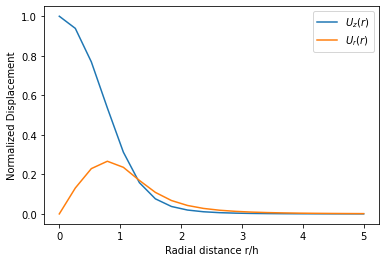

In [68]:
#Plot results
r = np.linspace(0, 5, num=arr_size)

uz_max = -uz_plot[0]
fig, ax = plt.subplots()
ax.set(xlabel='Radial distance r/h', ylabel='Normalized Displacement')
ax.plot(r, -uz_plot/uz_max, label=r"$U_z(r)$")
ax.plot(r, ur_plot/uz_max, label=r"$U_r(r)$")
ax.legend()
plt.show()


2.6793215192861815 0.7139051968137697


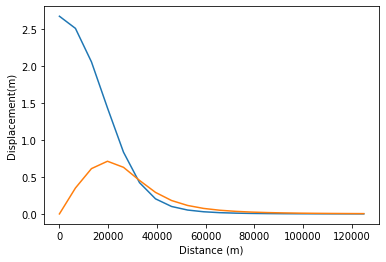

In [69]:
fig, ax = plt.subplots()
ax.set(xlabel='Distance (m)', ylabel='Displacement(m)')
ax.plot(r*R, -uz_plot*(2*(1-nu))*(R*p/mu), label=r"$U_z(r)$")
ax.plot(r*R, ur_plot*(2*(1-nu))*(R*p/mu), label=r"$U_z(r)$")

print(max(-uz_plot*(2*(1-nu))*(R*p/mu)), max(ur_plot*(2*(1-nu))*(R*p/mu)))

plt.show()

In [70]:
def read_h5(file_path):
    
    line_width = 3e3 #The width of the line (a mesh with infinite points would need 0 width)
    
    time_step = 0
     
    
    #prepare lists for getting data from hdf5 files
    with h5py.File(file_path, "r") as f:
        
        line_width = 10e3 #The width of the line (a mesh with infinite points would need 0 width)
        mesh_width = 130e3 #width of mesh from 0 to edge
            
        #Get the HDF5 groups
        group_geometry = f['geometry']
        group_vert_fields = f['vertex_fields']
        
        points = group_geometry['vertices'] #shape: point_num, xyz
        displacements = group_vert_fields['displacement'] #shape: timestep, point_num, xyz
        velocities = group_vert_fields['velocity'] #shape: timestep, point_num, xyz
        
        x = points[:][:,0]
        y = points[:][:,1]
        
        disp_x = displacements[time_step][:][:,0]
        disp_y = displacements[time_step][:][:,1]
        disp_z = displacements[time_step][:][:,2]
        
        vel_x = velocities[time_step][:][:,0]
        vel_y = velocities[time_step][:][:,1]
        vel_z = velocities[time_step][:][:,2]
        
        #interpolate data 
        #get points to interpolate
        theta = None
        x_i = np.linspace(0, mesh_width, 100)
        if theta == None:
            y_i = np.zeros(len(x_i))
        else:
            x_i = np.cos(theta)*x_i
            y_i = np.sin(theta)*x_i
        
        #interpolate
#         print(np.asarray([x,y]).T.shape)
#         print(np.asarray([x_i, y_i]).T.shape)
       # print(len(x))
        disp_x_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(disp_x), np.asarray([x_i, y_i]).T, method='cubic')
        disp_y_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(disp_y), np.asarray([x_i, y_i]).T, method='cubic')
        disp_z_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(disp_z), np.asarray([x_i, y_i]).T, method='cubic')
        
        vel_x_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(vel_x), np.asarray([x_i, y_i]).T, method='cubic')
        vel_y_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(vel_y), np.asarray([x_i, y_i]).T, method='cubic')
        vel_z_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(vel_z), np.asarray([x_i, y_i]).T, method='cubic')
        
    return (x_i, disp_x_interp, disp_y_interp, disp_z_interp, vel_x_interp, vel_y_interp, vel_z_interp)

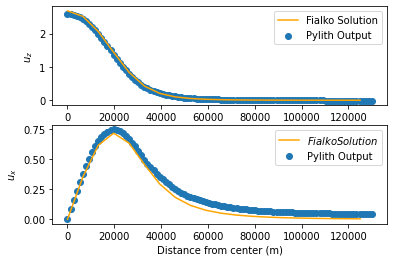

In [72]:
#------------------------------------------------#
# Import and plot Pylith model data
#------------------------------------------------#
x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5("../output_benchmark/OneLayerElastic-groundsurf.h5")


#NEED TO RERUN ONE LAYER ELASTIC WITH UPDATED MESH
#Plot data
fig, ax = plt.subplots(2)
ax[0].set(xlabel='Distance from center (m)', ylabel=r'$u_z$')
ax[0].scatter(x, disp_z, label='Pylith Output')
ax[0].plot(r*R, -uz_plot*(2*(1-nu))*(R*p/mu), label=r"Fialko Solution", c='orange')
ax[0].legend()

ax[1].set(xlabel='Distance from center (m)', ylabel=r'$u_x$')
ax[1].scatter(x, disp_x, label='Pylith Output')
ax[1].plot(r*R, ur_plot*(2*(1-nu))*(R*p/mu), label=r"$Fialko Solution$", c='orange')


plt.legend()
plt.savefig("../../Figures/FullyElasticBenchmark_small.png")
plt.show()

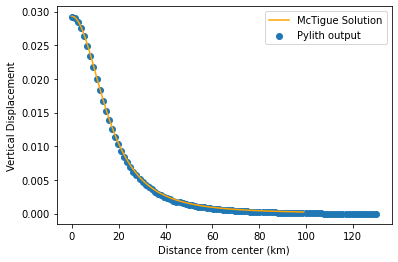

In [75]:
x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5("../output_benchmark/SphericalSource-groundsurf.h5")
r = np.arange(0.0, 100000, 1000)

plt.ylabel("Vertical Displacement")
plt.xlabel("Distance from center (km)")
plt.scatter(x/1e3, disp_z, label="Pylith output")
plt.plot(r/1e3, mctigue(r), label="McTigue Solution", color="orange")
plt.legend()
plt.savefig("../../Figures/McTigueBenchmark_small.png")

plt.show()